In [39]:
from data_prep.utils.config import setup_logging
import logging
setup_logging(log_level=logging.INFO)

# Set working directory to project root
from pathlib import Path
import os
from pyhere import here

os.chdir(here())

In [40]:
import pandas as pd
from pathlib import Path
import rioxarray as rxr
import xarray as xr


In [41]:
# Load the EV data
ev_folder = Path("data/evs/")
boundary_path = Path("data/processed/boundary.geojson")


# Try to load the merged dataset first
merged_path = ev_folder / "all-evs.tif"


ev_stack = rxr.open_rasterio(merged_path, masked=True, band_as_variable=True)

# rename bands

name_mapping = {ev_stack[var].name : ev_stack[var].attrs["long_name"] for var in ev_stack.data_vars}

ev_stack = ev_stack.rename(name_mapping)

ev_stack

<xarray.Dataset> Size: 613MB
Dimensions:                               (x: 1790, y: 1403)
Coordinates:
  * x                                     (x) float64 14kB 3.632e+05 ... 5.42...
  * y                                     (y) float64 11kB 3.786e+05 ... 5.18...
    spatial_ref                           int64 8B 0
Data variables: (12/61)
    ceh_landcover_broadleaved_woodland    (y, x) float32 10MB ...
    ceh_landcover_coniferous_woodland     (y, x) float32 10MB ...
    ceh_landcover_arable                  (y, x) float32 10MB ...
    ceh_landcover_improved_grassland      (y, x) float32 10MB ...
    ceh_landcover_urban                   (y, x) float32 10MB ...
    ceh_landcover_suburban                (y, x) float32 10MB ...
    ...                                    ...
    climate_bioclim_bio_15                (y, x) float32 10MB ...
    climate_bioclim_bio_16                (y, x) float32 10MB ...
    climate_bioclim_bio_17                (y, x) float32 10MB ...
    climate_bioclim_bio_18                (y, x) float32 10MB ...
    climate_bioclim_bio_19                (y, x) float32 10MB ...
    bgs_coast_distance_to_coast           (y, x) float32 10MB ...
Attributes:
    AREA_OR_POINT:  Area

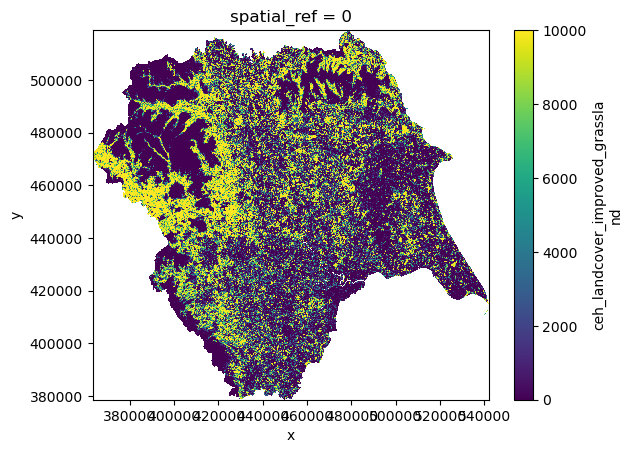

In [42]:
ev_stack["ceh_landcover_improved_grassland"].plot()

# Run some Checks

In [43]:
ev_df = ev_stack.to_dataframe()
ev_df.head()

spatial_ref  ceh_landcover_broadleaved_woodland  \
x        y                                                           
363250.0 378650.0            0                                 NaN   
         378750.0            0                                 NaN   
         378850.0            0                                 NaN   
         378950.0            0                                 NaN   
         379050.0            0                                 NaN   

                   ceh_landcover_coniferous_woodland  ceh_landcover_arable  \
x        y                                                                   
363250.0 378650.0                                NaN                   NaN   
         378750.0                                NaN                   NaN   
         378850.0                                NaN                   NaN   
         378950.0                                NaN                   NaN   
         379050.0                                NaN                   NaN   

                   ceh_landcover_improved_grassland  ceh_landcover_urban  \
x        y                                                                 
363250.0 378650.0                               NaN                  NaN   
         378750.0                               NaN                  NaN   
         378850.0                               NaN                  NaN   
         378950.0                               NaN                  NaN   
         379050.0                               NaN                  NaN   

                   ceh_landcover_suburban  ceh_landcover_grassland  \
x        y                                                           
363250.0 378650.0                     NaN                      NaN   
         378750.0                     NaN                      NaN   
         378850.0                     NaN                      NaN   
         378950.0                     NaN                      NaN   
         379050.0                     NaN                      NaN   

                   ceh_landcover_upland_heathland  ceh_landcover_wetland  ...  \
x        y                                                                ...   
363250.0 378650.0                             NaN                    NaN  ...   
         378750.0                             NaN                    NaN  ...   
         378850.0                             NaN                    NaN  ...   
         378950.0                             NaN                    NaN  ...   
         379050.0                             NaN                    NaN  ...   

                   climate_bioclim_bio_11  climate_bioclim_bio_12  \
x        y                                                          
363250.0 378650.0                     NaN                     NaN   
         378750.0                     NaN                     NaN   
         378850.0                     NaN                     NaN   
         378950.0                     NaN                     NaN   
         379050.0                     NaN                     NaN   

                   climate_bioclim_bio_13  climate_bioclim_bio_14  \
x        y                                                          
363250.0 378650.0                     NaN                     NaN   
         378750.0                     NaN                     NaN   
         378850.0                     NaN                     NaN   
         378950.0                     NaN                     NaN   
         379050.0                     NaN                     NaN   

                   climate_bioclim_bio_15  climate_bioclim_bio_16  \
x        y                                                          
363250.0 378650.0                     NaN                     NaN   
         378750.0                     NaN                     NaN   
         378850.0                     NaN                     NaN   
         378950.0                     NaN                     NaN   
       

In [44]:
ev_df.drop(columns=["spatial_ref"], inplace=True)

## Missing Values

There should be some missing values where I've clipped the data using a buffer but it should be less than 45%.

In [45]:
# Count the missing values per variable and sor tin descending order
baseline_missing : float = 0.45
ev_df.isna().mean().sort_values(ascending=False).to_frame(name="missing_fraction").query("missing_fraction > @baseline_missing")

,missing_fraction


## Visualise some of the missing values


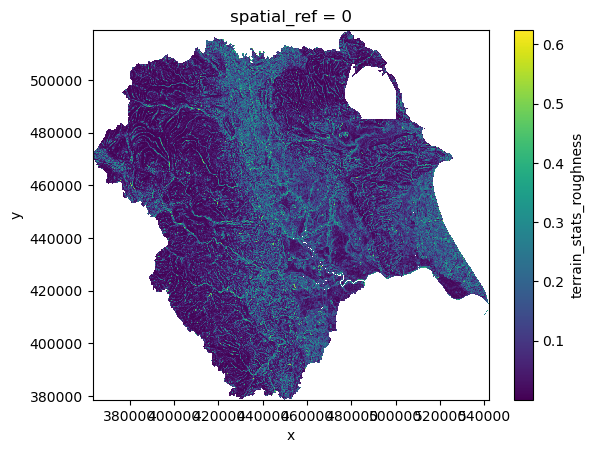

In [46]:
ev_stack["terrain_stats_roughness"].plot()

Where are the missing values in the dataset?

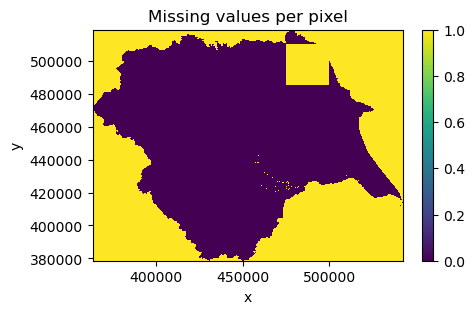

In [47]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3))
np.isnan(ev_stack.to_array()).any(axis=0).plot(ax = ax)
# add title
ax.set_title("Missing values per pixel")

plt.show()


# Visualise the EV Distributions


/var/folders/w6/z6wv9w5s4r77c8m0lp63lm1w0000gp/T/ipykernel_85661/3896634676.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=ev_df_melted, y='Variable', x='Value', scale='width', inner='quartile')


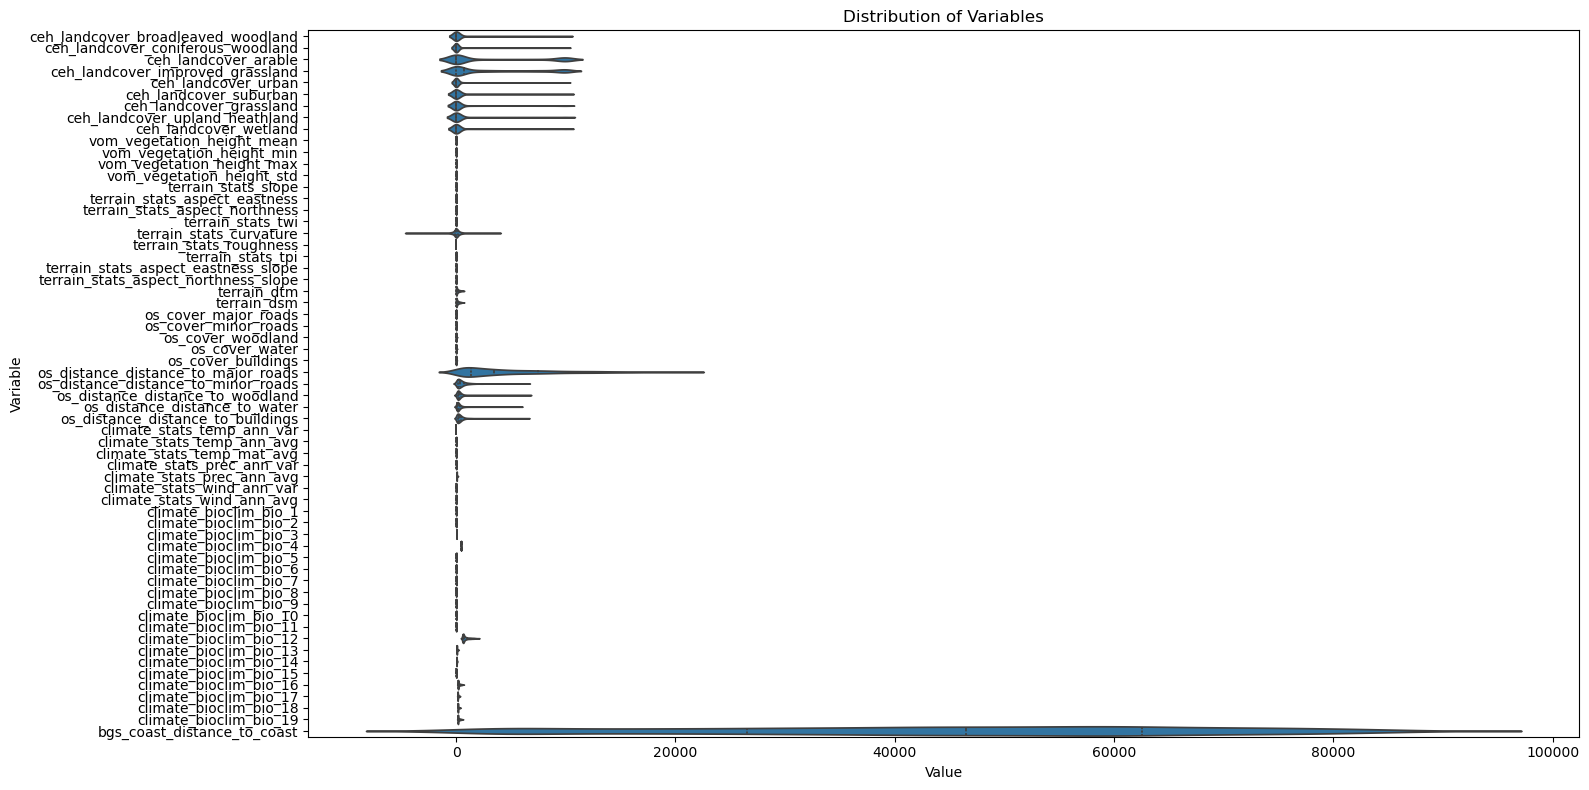

In [48]:
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# Melt the DataFrame to long format for seaborn
ev_df_melted = ev_df.reset_index().sample(10_000).melt(id_vars=['x', 'y'], var_name='Variable', value_name='Value')

# Create the violin plot
plt.figure(figsize=(16, 8))
sns.violinplot(data=ev_df_melted, y='Variable', x='Value', scale='width', inner='quartile')

plt.title('Distribution of Variables')
plt.tight_layout()
plt.show()

# Calculate EV Correlations

In [49]:
ev_df.dropna(inplace=True)

ev_correlations = ev_df.sample(10_000).corr()
ev_correlations.head()

,ceh_landcover_broadleaved_woodland,ceh_landcover_coniferous_woodland,ceh_landcover_arable,ceh_landcover_improved_grassland,ceh_landcover_urban,ceh_landcover_suburban,ceh_landcover_grassland,ceh_landcover_upland_heathland,ceh_landcover_wetland,vom_vegetation_height_mean,...,climate_bioclim_bio_11,climate_bioclim_bio_12,climate_bioclim_bio_13,climate_bioclim_bio_14,climate_bioclim_bio_15,climate_bioclim_bio_16,climate_bioclim_bio_17,climate_bioclim_bio_18,climate_bioclim_bio_19,bgs_coast_distance_to_coast
ceh_landcover_broadleaved_woodland,1.000000,0.053068,-0.185446,-0.060544,-0.046811,-0.057432,-0.084010,-0.083933,-0.074135,0.657844,...,0.090434,-0.080301,-0.075443,-0.071148,-0.040658,-0.075714,-0.069805,-0.091928,-0.070906,0.095945
ceh_landcover_coniferous_woodland,0.053068,1.000000,-0.106798,-0.084980,-0.027242,-0.044373,-0.018190,-0.007290,-0.029805,0.516911,...,-0.119038,0.089290,0.086671,0.094956,0.097977,0.089036,0.093213,0.088573,0.088882,0.015896
ceh_landcover_arable,-0.185446,-0.106798,1.000000,-0.475521,-0.131777,-0.234012,-0.230876,-0.223644,-0.178500,-0.206138,...,0.385273,-0.498143,-0.501829,-0.504329,-0.546745,-0.504336,-0.508026,-0.480384,-0.510118,-0.358684
ceh_landcover_improved_grassland,-0.060544,-0.084980,-0.475521,1.000000,-0.111729,-0.141299,-0.196945,-0.198857,-0.192713,-0.006255,...,0.134659,-0.063142,-0.061023,-0.059556,0.036267,-0.056608,-0.061579,-0.065220,-0.061290,0.092905
ceh_landcover_urban,-0.046811,-0.027242,-0.131777,-0.111729,1.000000,0.197695,-0.065923,-0.062844,-0.050649,-0.038579,...,0.149515,-0.086427,-0.078272,-0.089508,-0.057351,-0.081538,-0.081492,-0.100074,-0.076021,0.081514


Some of the correlations ar NA because the values are all 0 in the dataset. This is where that land cover feature doesn't exist inland and should just be converted to NA.

In [50]:
ev_correlations.fillna(0, inplace=True)

/var/folders/w6/z6wv9w5s4r77c8m0lp63lm1w0000gp/T/ipykernel_85661/2209991609.py:7: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance, method='ward')


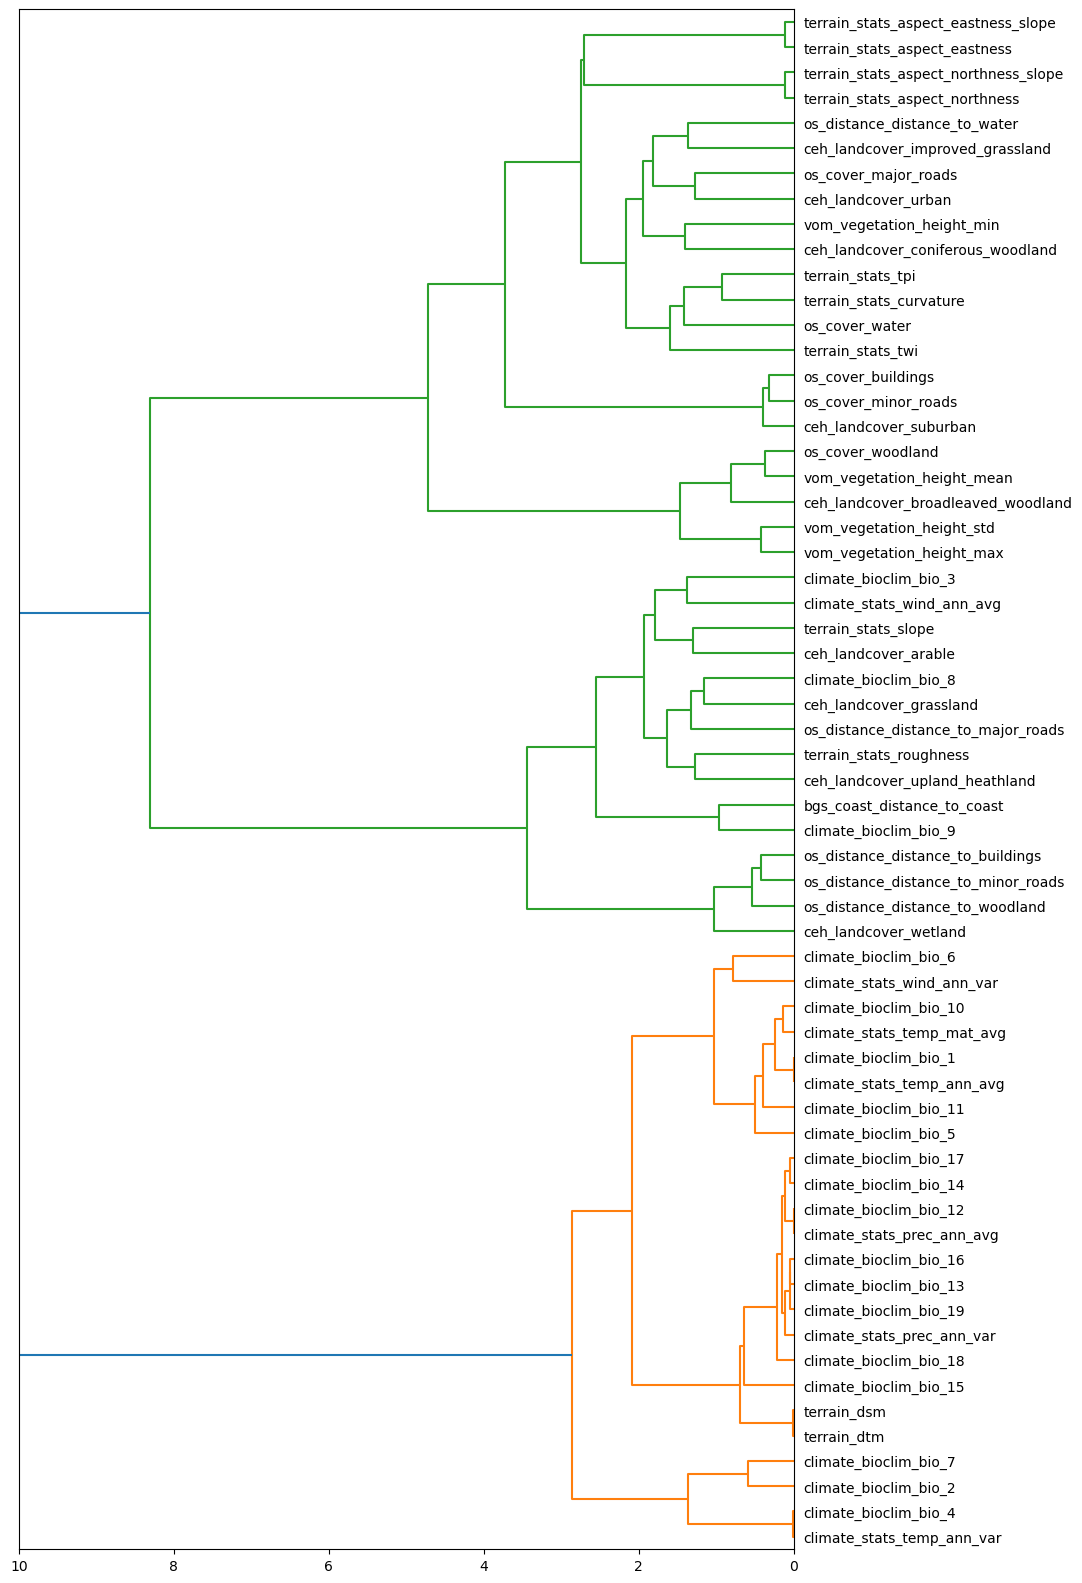

In [51]:
from scipy.cluster import hierarchy

# Calculate distance between each variable (1 - correlation to have a sense of distance)
distance = 1 - ev_correlations.abs()

# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(distance, method='ward')

plt.figure(figsize=(10,20))
hierarchy.dendrogram(linkage_matrix, labels=ev_correlations.columns.tolist(), orientation="left", leaf_font_size=10)
plt.xlim(10, 0)
plt.show()

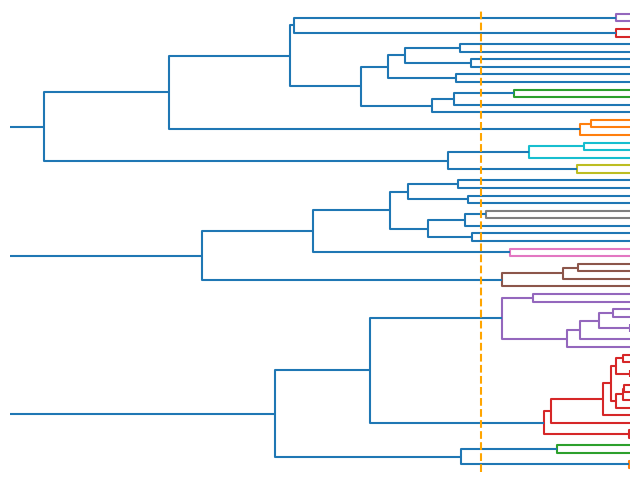

In [52]:

plt.figure(figsize=(8,6))

cut_height = 1.2
hierarchy.dendrogram(
    linkage_matrix,
    no_labels=True, 
    orientation="left",
    color_threshold=cut_height,
    )
# add a vertical line to mark the threshold
plt.axvline(x=cut_height, color='orange', linestyle='--')
plt.xlim(5, 0)
# drop the panel
plt.gca().set_axis_off()
background_color = "#eeeeee"
# set panel background color
plt.gca().patch.set_facecolor(background_color)
plt.show()

In [53]:
# Cluster the samples
cluster_ids = hierarchy.fcluster(linkage_matrix, t=1.2, criterion='distance')

# Create a DataFrame to see clusters
column_clusters = pd.DataFrame({'cluster_id': cluster_ids, 'column_name': ev_df.columns})
print(column_clusters.cluster_id.value_counts().sort_index())

1      2
2      2
3     12
4      8
5      4
6      2
7      1
8      1
9      2
10     1
11     1
12     1
13     1
14     1
15     2
16     3
17     3
18     2
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     2
28     2
Name: cluster_id, dtype: int64


In [54]:
column_clusters = column_clusters.sort_values("cluster_id")
column_clusters.to_csv("data/evs/ev_clusters.csv", index=False)

## Feature Engineering

In [55]:
[var for var in 
"""
os_cover_buildings
os_cover_minor_roads
""".split("\n") if var != ""]

['os_cover_buildings', 'os_cover_minor_roads']

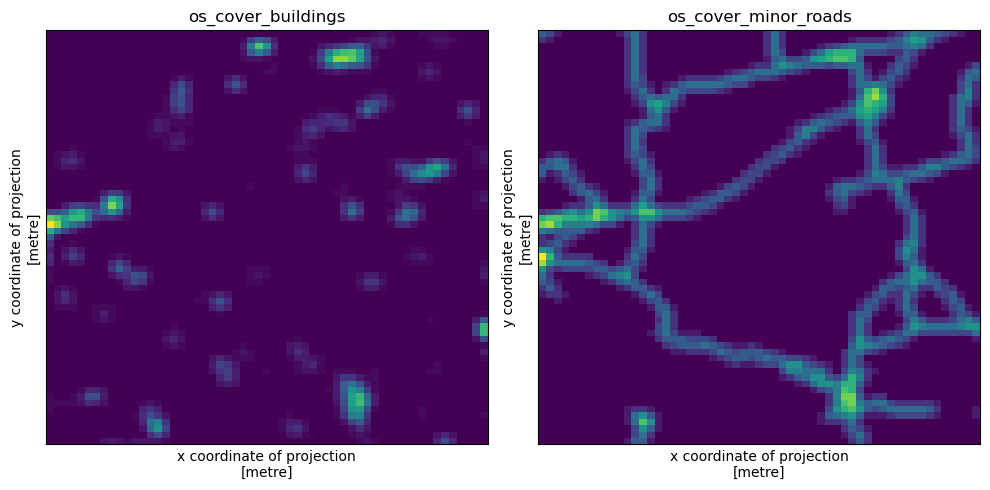

In [56]:
variables = ['os_cover_buildings', 'os_cover_minor_roads']


viz_bbox = (449300 , 440557, 454938 , 446969)

def calculate_grid(num_plots:int, max_width:int) -> tuple[int, int]:
    """
    Calculate the number of rows and columns for a grid of plots.
    """
    # Calculate the number of rows and columns
    num_cols = min(num_plots, max_width)
    num_rows = int(np.ceil(num_plots / num_cols))
    return num_rows, num_cols

def calculate_figsize(num_plots:int, max_width:int) -> tuple[float, float]:
    """
    Calculate the figure size for a grid of plots.
    """
    # Calculate the number of rows and columns
    num_rows, num_cols = calculate_grid(num_plots, max_width)
    # Calculate the figure size
    fig_width = 5 * num_cols
    fig_height = 5 * num_rows
    return fig_width, fig_height

# plot the variables (small)
import matplotlib.pyplot as plt
import numpy as np

ev_stack_clipped = ev_stack.rio.clip_box(*viz_bbox, crs=27700)


def plot_dataset(dataset:xr.Dataset, max_cols:int):
    variables = dataset.data_vars.keys()
    
    num_rows, num_cols = calculate_grid(len(variables), max_cols)
    fig_width, fig_height = calculate_figsize(len(variables), max_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), sharex=True, sharey=True)
    for var, ax in zip(variables, axes.flatten()):
        dataset[var].plot(ax=ax, cmap="viridis", add_colorbar=False)
        ax.set_title(var)
        ax.set_xticks([])
        ax.set_yticks([])
        # add a grid
        ax.grid(False)

    # remove empty subplots
    for ax in axes.flatten()[len(variables):]:
        ax.remove()
    plt.tight_layout()
    plt.show()
plot_dataset(ev_stack_clipped[variables], max_cols=3)

In [57]:
# import PCA from sklearn and extract the first 3 components
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

num_components = min(3, len(variables))
# Create a pipeline to standardize the data and then apply PCA
pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=num_components)
)
# Fit the pipeline to the data
X = ev_df[variables].dropna().values
pipeline.fit(X)


def extract_components(dataset: xr.Dataset, model: Pipeline, num_components: int) -> xr.Dataset:
    """
    Extract PCA components from an xarray Dataset.
    
    Parameters:
    -----------
    dataset : xr.Dataset
        Input dataset containing environmental variables
    model : Pipeline
        Fitted sklearn pipeline with StandardScaler and PCA
    num_components : int
        Number of PCA components to extract
    
    Returns:
    --------
    xr.Dataset
        Dataset containing the PCA components
    """
    # Convert the dataset to a DataArray
    array = dataset.to_array()
    
    # Get the original dimensions and coordinates
    dims = array.dims
    coords = {dim: array.coords[dim] for dim in dims}
    
    # Extract numpy array values
    np_array = array.values
    
    # Get the shape information
    array_shape = np_array.shape
    num_vars, height, width = array_shape
    
    # Reshape to (samples, features) for sklearn - this is (pixels, variables)
    np_array_2d = np_array.reshape(num_vars, -1).T
    
    # Apply PCA transformation
    np_array_transformed = model.transform(np_array_2d)
    
    # Reshape back to spatial representation (components, height, width)
    np_array_3d = np_array_transformed.T.reshape(num_components, height, width)
    
    # Create output variable names
    var_names = [f"pca_{i}" for i in range(num_components)]
    
    # Create a new xarray dataset for the PCA components
    pca_dataset = xr.Dataset()
    
    # Add each component as a data variable
    for i, name in enumerate(var_names):
        pca_dataset[name] = xr.DataArray(
            np_array_3d[i],
            dims=('y', 'x'),
            coords={
                'y': coords['y'],
                'x': coords['x']
            }
        )
    
    # Copy spatial reference if available
    if 'spatial_ref' in dataset.coords:
        pca_dataset.coords['spatial_ref'] = dataset.coords['spatial_ref']
    
    return pca_dataset

ev_stack_clipped_pca = extract_components(ev_stack_clipped[variables], pipeline, num_components)



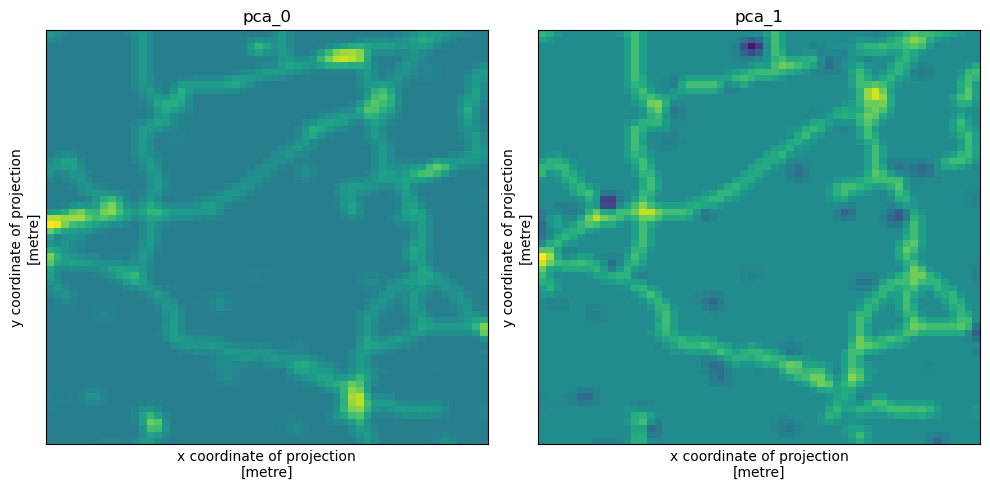

In [58]:
plot_dataset(ev_stack_clipped_pca, max_cols=3)

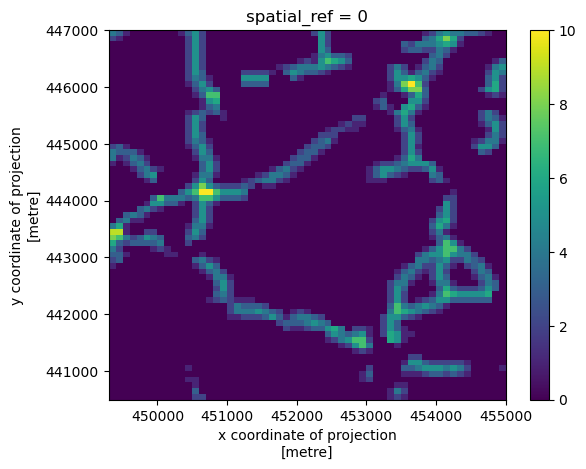

In [59]:
rural_roads = ev_stack_clipped["os_cover_minor_roads"] - ev_stack_clipped["os_cover_buildings"]
rural_roads = rural_roads.where(rural_roads > 0, 0)

rural_roads.plot()

In [60]:
def scale_01(array:xr.DataArray) -> xr.DataArray:
    """
    Scale an xarray DataArray to the range [0, 1].
    
    Parameters:
    -----------
    array : xr.DataArray
        Input data array to be scaled
    
    Returns:
    --------
    xr.DataArray
        Scaled data array
    """
    return (array - array.min()) / (array.max() - array.min())


In [61]:
confierous = ev_stack_clipped["ceh_landcover_coniferous_woodland"]
broadleaved = ev_stack_clipped["ceh_landcover_broadleaved_woodland"]
os_woodland = ev_stack_clipped["os_cover_woodland"]

veg_height_mean = ev_stack_clipped["vom_vegetation_height_mean"]


veg_height_mean_coniferous = veg_height_mean * scale_01(confierous)
veg_height_mean_broadleaved = veg_height_mean * scale_01(broadleaved)

veg_height_scrub_other = veg_height_mean * (1- scale_01(os_woodland + confierous + broadleaved))

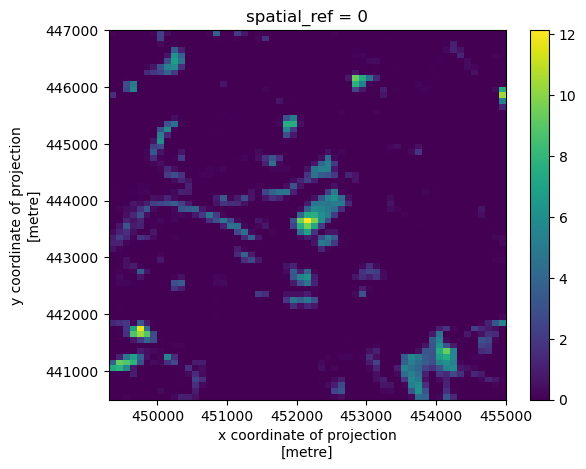

In [62]:
veg_height_mean_broadleaved.plot()

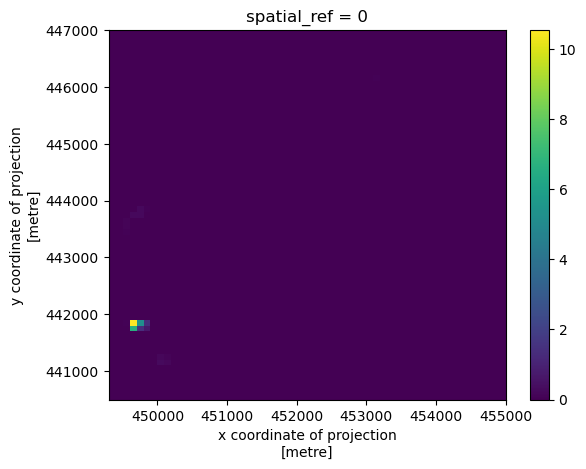

In [63]:
veg_height_mean_coniferous.plot()

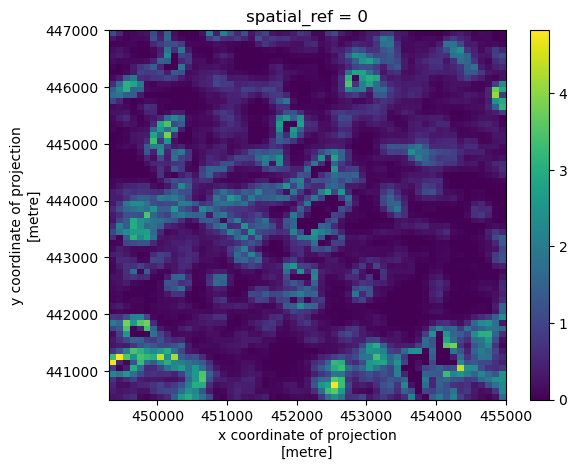

In [64]:
veg_height_scrub_other.plot()

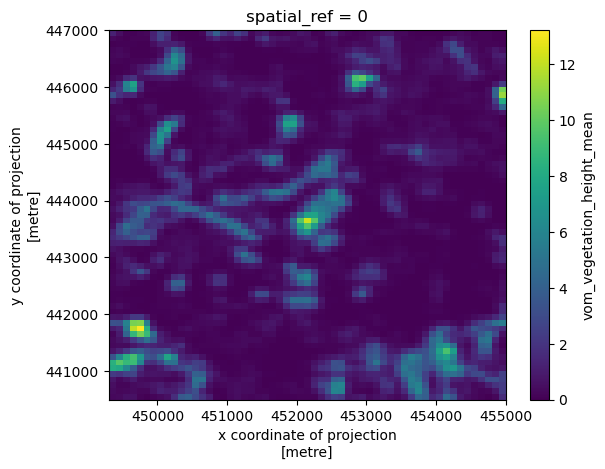

In [65]:
veg_height_mean.plot()

## Prune EVs

In [66]:
selected_var_path = Path("data/evs/ev_clusters_selected.csv")

# Check if the file exists
assert selected_var_path.exists(), f"File {selected_var_path} does not exist. Please run the clustering script and select EVs first."

selectecd_vars_df = pd.read_csv("data/evs/ev_clusters_selected.csv")

keep_evs = selectecd_vars_df[selectecd_vars_df["include"] == 1].column_name.tolist()
print(keep_evs)

['climate_stats_temp_ann_var', 'climate_bioclim_bio_7', 'terrain_dtm', 'climate_stats_prec_ann_avg', 'climate_stats_temp_ann_avg', 'ceh_landcover_wetland', 'os_distance_distance_to_buildings', 'climate_bioclim_bio_9', 'bgs_coast_distance_to_coast', 'ceh_landcover_upland_heathland', 'terrain_stats_roughness', 'ceh_landcover_grassland', 'climate_bioclim_bio_8', 'os_distance_distance_to_major_roads', 'ceh_landcover_arable', 'terrain_stats_slope', 'climate_stats_wind_ann_avg', 'climate_bioclim_bio_3', 'vom_vegetation_height_max', 'ceh_landcover_broadleaved_woodland', 'vom_vegetation_height_mean', 'ceh_landcover_suburban', 'terrain_stats_tpi', 'os_cover_water', 'terrain_stats_twi', 'ceh_landcover_coniferous_woodland', 'ceh_landcover_urban', 'ceh_landcover_improved_grassland', 'os_distance_distance_to_water', 'terrain_stats_aspect_northness_slope', 'terrain_stats_aspect_eastness_slope']


In [67]:
# Subset the xr dataset to  only include the variables with the keep evs names
evs_to_model = ev_stack[keep_evs]
evs_to_model

<xarray.Dataset> Size: 311MB
Dimensions:                               (y: 1403, x: 1790)
Coordinates:
  * x                                     (x) float64 14kB 3.632e+05 ... 5.42...
  * y                                     (y) float64 11kB 3.786e+05 ... 5.18...
    spatial_ref                           int64 8B 0
Data variables: (12/31)
    climate_stats_temp_ann_var            (y, x) float32 10MB nan nan ... nan
    climate_bioclim_bio_7                 (y, x) float32 10MB nan nan ... nan
    terrain_dtm                           (y, x) float32 10MB nan nan ... nan
    climate_stats_prec_ann_avg            (y, x) float32 10MB nan nan ... nan
    climate_stats_temp_ann_avg            (y, x) float32 10MB nan nan ... nan
    ceh_landcover_wetland                 (y, x) float32 10MB nan nan ... nan
    ...                                    ...
    ceh_landcover_coniferous_woodland     (y, x) float32 10MB nan nan ... nan
    ceh_landcover_urban                   (y, x) float32 10MB nan nan ... nan
    ceh_landcover_improved_grassland      (y, x) float32 10MB nan nan ... nan
    os_distance_distance_to_water         (y, x) float32 10MB nan nan ... nan
    terrain_stats_aspect_northness_slope  (y, x) float32 10MB nan nan ... nan
    terrain_stats_aspect_eastness_slope   (y, x) float32 10MB nan nan ... nan
Attributes:
    AREA_OR_POINT:  Area

# Multi-Scale EVs

In [68]:

def calculate_multiscale_variables(dataset: xr.Dataset, window: int) -> xr.Dataset:
    original_names = dataset.data_vars

    vars = (
        dataset.rolling(x=window, y=window, center=True)
        .mean(skipna=True)
        .rename(
            {name: f"{name}_{round((window/2) * 100)}m" for name in dataset.data_vars}
        )
    )
    # Assign nodata from the original dataset
    for new_name, old_name in zip(vars.data_vars, original_names):
        vars[new_name].rio.write_nodata(
            dataset[old_name].rio.nodata, inplace=True
        )
        vars[new_name].attrs["long_name"] = new_name


    return vars


In [69]:


resolution = 100  # m
windows = [10] # 300m, 500m, 1000m


multiscale_groups = [
    "ceh_landcover",
    "os_cover",
    "vom"
]



multiscale_variables = [
    var for var in evs_to_model.data_vars
    if any([str(var).startswith(group) for group in multiscale_groups])
]

# Check the variable exists in the dataset
assert all([var in evs_to_model.data_vars for var in multiscale_variables])

# Calculate the average for each variable within the focal window
# and add the variable name as a suffix


# Calculate the multiscale variables for each window size
multiscale_datasets = [calculate_multiscale_variables(evs_to_model[multiscale_variables], window) for window in windows]
multiscale_datasets = xr.merge(multiscale_datasets)

In [70]:
evs_multiscale = xr.merge([evs_to_model, multiscale_datasets])

# Write to output

In [71]:
evs_final = evs_multiscale


evs_final.rio.to_raster(
    "data/evs/evs-to-model.tif",
)

# Write Grid Points


In [72]:
import geopandas as gpd


# Convert the dataset into an array of bools defining null values
null_cells = evs_final.to_array().isnull().any(dim="variable")
null_cells_df = null_cells.to_dataframe(name="any_null").reset_index().drop(columns="spatial_ref")
valid_cells_df = null_cells_df[null_cells_df.any_null == False].drop(columns="any_null")

grid_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(valid_cells_df.x, valid_cells_df.y),
    crs=evs_final.rio.crs,
    index=valid_cells_df.index,
)

grid_points.head()
grid_point_path = Path("data/evs/grid-points.parquet")
# Save the grid points to a geojson
grid_points.to_parquet(
    grid_point_path,
)

/opt/homebrew/anaconda3/envs/bats/lib/python3.11/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
/var/folders/w6/z6wv9w5s4r77c8m0lp63lm1w0000gp/T/ipykernel_85661/1869843013.py:1: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [73]:
grid_point_path.absolute()

PosixPath('/Users/work/Data Science/sheffield-bats/data/evs/grid-points.parquet')